In [1]:
import netket as nk
import json
from qutip import *
import numpy as np
import time
import multiprocessing as mp
from collections import OrderedDict
from pickle import dump
import os
import matplotlib.pyplot as plt
import scipy
from matplotlib import gridspec
from functools import reduce
plt.style.use('seaborn')
from scipy.stats import norm
import sys
sys.path.append("/Users/victorwei/Research projects/Neural Network Quantum State/penalty excited states")
sys.path.append("/Users/victorwei/Research projects/Neural Network Quantum State/2022_winter_analysis")
import expect_grad_ex
import vmc_ex
import jax
import optax

from typing import Callable, Optional
from functools import partial

import jax
import jax.numpy as jnp

from netket.utils.types import PyTree, Array
import netket.jax as nkjax

from netket.vqs.mc import (
    kernels,
    check_hilbert,
    get_local_kernel_arguments,
    get_local_kernel,
)

from netket.vqs.mc.mc_state.state import MCState

from netket.operator import (
    AbstractOperator,
    DiscreteOperator,
    Squared,
    ContinuousOperator,
)

from netket.vqs.mc import (
    get_local_kernel_arguments,
    get_local_kernel,
)
from netket.stats import Stats, statistics
import matplotlib
matplotlib.rcParams["figure.dpi"] = 200
plt.rcParams['text.usetex'] = True

In [2]:
#we define necessary functions here
def batch_discrete_kernel(kernel):
    """
    Batch a kernel that only works with 1 sample so that it works with a
    batch of samples.
    Works only for discrete-kernels who take two args as inputs
    """

    def vmapped_kernel(logpsi_1, logpsi_2, pars1, pars2, σ, args):
        """
        local_value kernel for MCState and generic operators
        """
        σp, mels = args

        if jnp.ndim(σp) != 3:
            σp = σp.reshape((σ.shape[0], -1, σ.shape[-1]))
            mels = mels.reshape(σp.shape[:-1])

        vkernel = jax.vmap(kernel, in_axes=(None, None,None,None, 0, (0, 0)), out_axes=0)
        return vkernel(logpsi_1, logpsi_2, pars1, pars2, σ, (σp, mels))

    return vmapped_kernel

#we first need to estabalish the kernel functions for evaluating expectation values
@partial(jax.jit, static_argnums=(0, 1))
@batch_discrete_kernel
def corr_kernel(logpsi_1: Callable, logpsi_2: Callable, pars1: PyTree, pars2: PyTree, σ: Array, args: PyTree):
    σp, mel = args


    return jnp.sum(mel * jnp.exp(logpsi_1(pars1, σp) - logpsi_2(pars2, σ)))


def get_local_kernel_arguments(vstate: MCState, Ô: DiscreteOperator):  # noqa: F811
    check_hilbert(vstate.hilbert, Ô.hilbert)

    σ = vstate.samples
    σp, mels = Ô.get_conn_padded(σ)
    
    return σ, (σp, mels)

In [3]:
#here is the function for expectation value
#input: operator, left_psi (rbm object, parameter finalized), right_psi (rbm object, parameter finalized)
def expect(operator, left_psi, right_psi):
    para1 = right_psi.parameters
    para2 = left_psi.parameters
    
    logpsi_1 = right_psi._apply_fun
    logpsi_2 = left_psi._apply_fun
    
    model_state1 = right_psi.model_state
    model_state2 = left_psi.model_state
    
    σ, args = get_local_kernel_arguments(left_psi, operator)

    σ_shape = σ.shape
    if jnp.ndim(σ) != 2:
        σ = σ.reshape((-1, σ_shape[-1]))

    psi_loc = corr_kernel(
            logpsi_1,
            logpsi_2,
            {"params": para1, **model_state1},
            {"params": para2, **model_state2},
            σ,
            args,
        )

    psi = statistics(psi_loc)
    print("expectation done once")
    return psi.mean

In [4]:
# this modified version only works with S+, S- operators since it excludes the ground state contribution
def evo_corr(t_obver, obver, sta_list, eng_list, t_end, t_step, n_samples):
    num_step = int(np.around(t_end / t_step))
    time = []
    correlation = []
    initial_list = []
    
    #re-set the number of samples
    for ii in range(len(eng_list)):
        sta_list[ii].reset()
        sta_list[ii].n_samples = n_samples
    
    for j in range(len(eng_list)-1):
        initial_list.append(expect(t_obver, sta_list[0], sta_list[j+1]) * expect(obver, sta_list[j+1], sta_list[0]))
    
    for i in range(num_step+1):
        time.append(t_step*(i))
        corr_temp = complex(0,0)
        
        for j in range(len(eng_list)-1):
            op = np.exp(- 1j * (eng_list[j+1]-eng_list[0]) * t_step)
            initial_list[j] *= op
            corr_temp = sum(initial_list)


        correlation.append(corr_temp)
            
    return time, correlation

In [5]:
#below are standard functions we need for model setup
#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()
    

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

def CSHam(N, B, Ak):
    # Make graph with of length N with no periodic boundary conditions
    g = nk.graph.Hypercube(length=N, n_dim=1, pbc=False)
    # Spin based Hilbert Space
    hilbertSpace = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
    # Define spin operators with \hbar set to 1
    sz = 0.5 * np.array([[1, 0], [0, -1]])
    sx = 0.5 * np.array([[0, 1], [1, 0]])
    sy = 0.5 * np.array([[0, -1j], [1j, 0]])
    operators = []
    sites = []
    # Central spin term
    operators.append((B * sz).tolist()) #array to list(ordered and changeable)
    sites.append([0])
    # Interaction term
    itOp = np.kron(sz, sz) + np.kron(sx, sx) + np.kron(sy, sy) #kronecker product here
    for i in range(N - 1):
        operators.append((Ak[i] * itOp).tolist())
        sites.append([0, (i+1)])  #pretty convoluted indexing, but ok
    # Create hamiltonian
    hamiltonian = nk.operator.LocalOperator(hilbertSpace, operators=operators, acting_on=sites, dtype=complex)
    #acting_on specifier necessary as this is a central spin model
    return hamiltonian, hilbertSpace

def exactDiagonalization_full(hamiltonian):
    # Changes Hamiltonian to matrix form
    haMatrix = hamiltonian.to_dense()
    # Gets eigenvalues and vectors
    eigenValues, v = np.linalg.eigh(haMatrix)
    # Orders from smallest to largest
    eigenVectors = [v[:, i] for i in range(len(eigenValues))]
    return eigenValues, eigenVectors

def state_error(state_list, ex_state_list, N):
    state_er = []
    for i in range(len(state_list)):
        state_er_temp = err_sta(state_list[i], ex_state_list[i], N)
        state_er.append(state_er_temp)
    return state_er

# Error Calculation (Input: the found state, the state from exact diagonalization, the found energy, the energy from exact diagonalization)
def err_sta(state, edState,N):
    overlap = np.dot(state.conj().reshape(2**N, 1).T, edState.reshape(2**N, 1))
    waveFunctionErr = 1 - (np.linalg.norm(overlap))**2
    return waveFunctionErr

def eng_error(eng_list, ex_energy):
    eng_er = []
    for i in range(len(eng_list)):
        eng_er_temp = np.abs(eng_list[i] - ex_energy[i])
        eng_er.append(eng_er_temp)
    return eng_er

In [6]:
#now let's do some dynamics
N = 6
Ak = []

alpha = 1   #density of RBM
M = alpha*N
# Constant A
B = 0.95
# Variable A
A = N/2
N0 = N/2
for i in range(N-1):
    # Constant A
    #Ak_i = 1
    # Variable A
    Ak_i = A / (N0) * np.exp(-i / N0)
    Ak.append(Ak_i)
    
# Define hamiltonian and hilbert space
ha, hi = CSHam(N,B,Ak)


#Exact Diagonalization
e, v = exactDiagonalization_full(ha)

In [9]:
#we now need to create the plus and minus operator in netket local operator format
g = nk.graph.Hypercube(length=N, n_dim=1, pbc=False)
# Spin based Hilbert Space
hilbertSpace = nk.hilbert.Spin(s=0.5, N=g.n_nodes)
# Define spin operators with \hbar set to 1
sz = 0.5 * np.array([[1, 0], [0, -1]])
sx = 0.5 * np.array([[0, 1], [1, 0]])
sy = 0.5 * np.array([[0, -1j], [1j, 0]])
operators_p = []
operators_m = []
sites_p = []
sites_m = []

# plus operator
operators_p.append((sx + 1j * sy).tolist()) #array to list(ordered and changeable)
sites_p.append([0])
# Create plus operator
S_plus = nk.operator.LocalOperator(hilbertSpace, operators=operators_p, acting_on=sites_p, dtype=complex)

# minus operator
operators_m.append((sx - 1j * sy).tolist()) #array to list(ordered and changeable)
sites_m.append([0])
# Create plus operator
S_minus = nk.operator.LocalOperator(hilbertSpace, operators=operators_m, acting_on=sites_m, dtype=complex)

In [7]:
n_samples_global = 1000000
#now we need the inexact eigenstates in rbm representation
#we need to load the parameters first, then create a list of eigenstates
#this shit loads the ground state parameters
import pickle
fileName_0 = "eigenstate_data/parameter_N6i0j38_best-Copy1.json"
file_0 = open(fileName_0,'rb')
a0 = pickle.load(file_0)

fileName_1 = "eigenstate_data/parameter_N6i1j41_best-Copy1.json"
file_1 = open(fileName_1,'rb')
a1 = pickle.load(file_1)

fileName_2 = "eigenstate_data/parameter_N6i2j22_best-Copy1.json"
file_2 = open(fileName_2,'rb')
a2 = pickle.load(file_2)

fileName_3 = "eigenstate_data/parameter_N6i3j10_best-Copy1.json"
file_3 = open(fileName_3,'rb')
a3 = pickle.load(file_3)

n_samples = n_samples_global
alpha = 1
ma = nk.models.RBM(alpha=alpha, dtype=complex,use_visible_bias=True, use_hidden_bias=True)
sampler0 = nk.sampler.MetropolisLocal(hilbert=hi)
sampler1 = nk.sampler.MetropolisLocal(hilbert=hi)
sampler2 = nk.sampler.MetropolisLocal(hilbert=hi)
sampler3 = nk.sampler.MetropolisLocal(hilbert=hi)

vs_0 = nk.vqs.MCState(sampler0, ma, n_samples=n_samples, n_discard_per_chain=n_samples/10)
vs_0.parameters = a0
eng_0 = np.real(vs_0.expect(ha).mean)
vs_1 = nk.vqs.MCState(sampler1, ma, n_samples=n_samples, n_discard_per_chain=n_samples/10)
vs_1.parameters = a1
eng_1 = np.real(vs_1.expect(ha).mean)
vs_2 = nk.vqs.MCState(sampler2, ma, n_samples=n_samples, n_discard_per_chain=n_samples/10)
vs_2.parameters = a2
eng_2 = np.real(vs_2.expect(ha).mean)
vs_3 = nk.vqs.MCState(sampler3, ma, n_samples=n_samples, n_discard_per_chain=n_samples/10)
vs_3.parameters = a3
eng_3 = np.real(vs_3.expect(ha).mean)

state_list = [vs_0, vs_1, vs_2, vs_3]
eng_list = [eng_0, eng_1, eng_2, eng_3]

print(eng_list)

[DeviceArray(-1.41481988, dtype=float64), DeviceArray(-1.32740028, dtype=float64), DeviceArray(-1.27222185, dtype=float64), DeviceArray(-1.22021547, dtype=float64)]


In [10]:
time, corr = evo_corr(S_plus, S_minus, state_list, eng_list, 500, 0.01, n_samples_global)

expectation done once
expectation done once
expectation done once
expectation done once
expectation done once
expectation done once


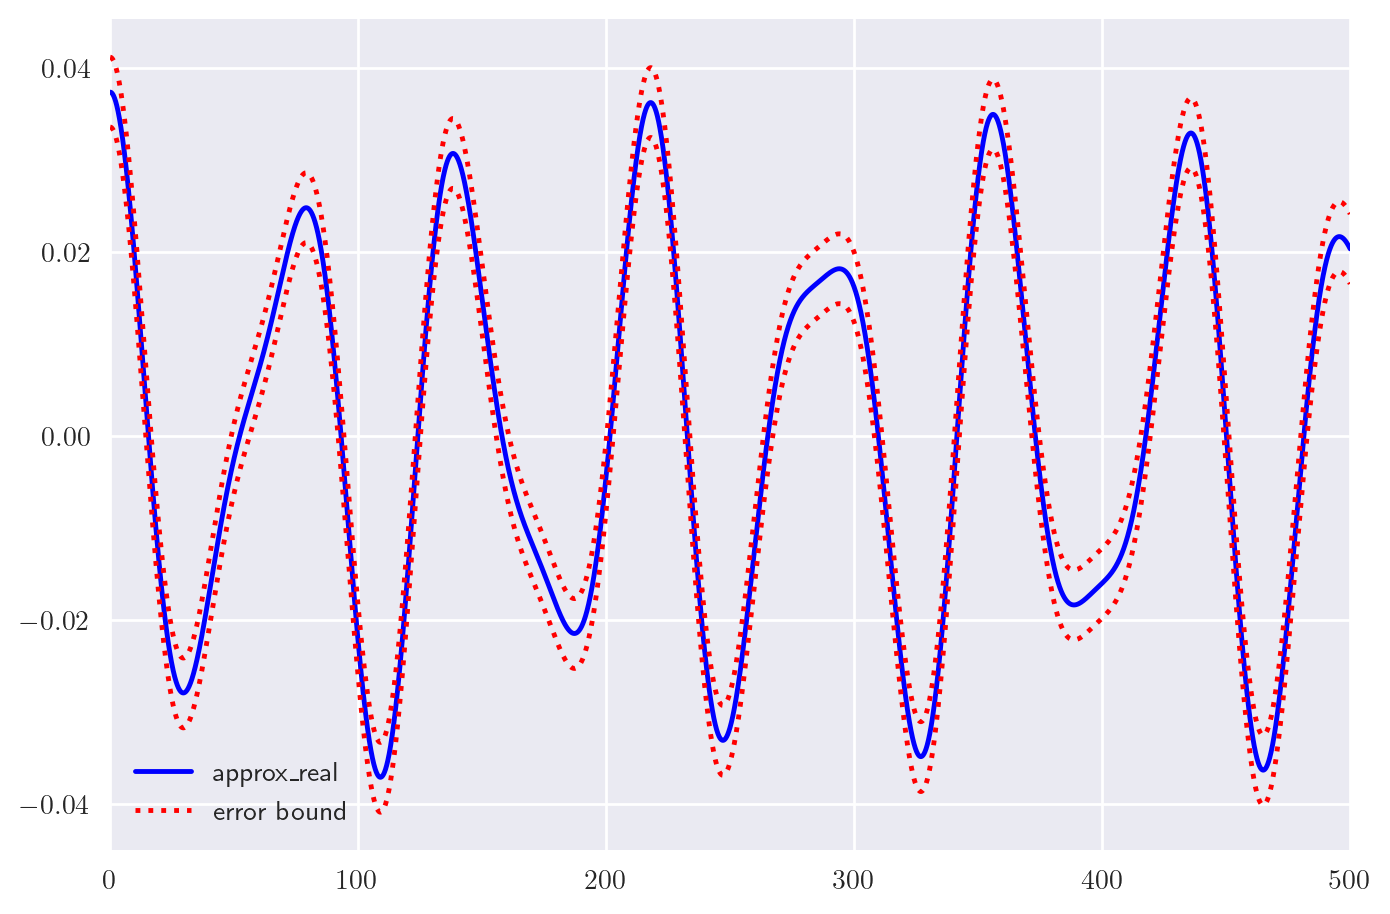

In [24]:
# let's plot!
plt.plot(time, np.real(corr), color='b', label = 'approx_real')
plt.plot(time, np.real(corr)+0.00379412, color='r', linestyle = ':', label = 'error bound')
plt.plot(time, np.real(corr)-0.00379412, color='r', linestyle = ':')
#plt.plot(time_ex, np.real(corr_ex), color='g', label = 'exact_real')
#plt.ylim(-0.383,-0.3829)
plt.legend()
plt.xlim(0, 500)
plt.show()

In [12]:
#let's also get the exact version
def expected_2(A, bra, ket):
        
    expectation = np.dot(np.conj(bra).T, np.matmul(A, ket) )
    return expectation


#evolve correlation function
def dense_evo_corr(t_obver, obver, sta_list, eng_list, t_end, t_step, N):
    num_step = int(np.around(t_end / t_step))
    time = []
    correlation = []
    initial_list = []
    
    
    for j in range(len(eng_list)-1):
        initial_list.append(expected_2(t_obver, sta_list[0], sta_list[j+1]) * expected_2(obver, sta_list[j+1], sta_list[0]))
    
    for i in range(num_step+1):
        time.append(t_step*(i))
        corr_temp = complex(0,0)
        
        for j in range(len(eng_list)-1):
            op = np.exp(- 1j * (eng_list[j+1]-eng_list[0]) * t_step)
            initial_list[j] *= op
            corr_temp = sum(initial_list)


        correlation.append(corr_temp)
            
    return time, correlation

#construct the S+0 and S-0 operators of interest
def S0_p(N):
    S0_p = []
    si = qeye(2)
    op_list = []
    for m in range(N):     
        op_list.append(si)
    op_list[0] = sigmap()
    S0_p.append(tensor(op_list))
    
    return S0_p[0]

def S0_m(N):
    S0_m = []
    si = qeye(2)
    op_list = []
    for m in range(N):     
        op_list.append(si)
    op_list[0] = sigmam()
    S0_m.append(tensor(op_list))
    
    return S0_m[0]

obver_p = np.array(S0_p(N))
obver_m = np.array(S0_m(N))

#let's get the exact value
dense_sta = []
for i in range(len(state_list)):
    dense_sta.append(state_list[i].to_array())
    


In [13]:
#time_dense, corr_dense = dense_evo_corr(obver_p, obver_m, dense_sta, eng_list, 500, 0.005, N )

time_ex, corr_ex = dense_evo_corr(obver_p, obver_m, v, e, 500, 0.01, N )

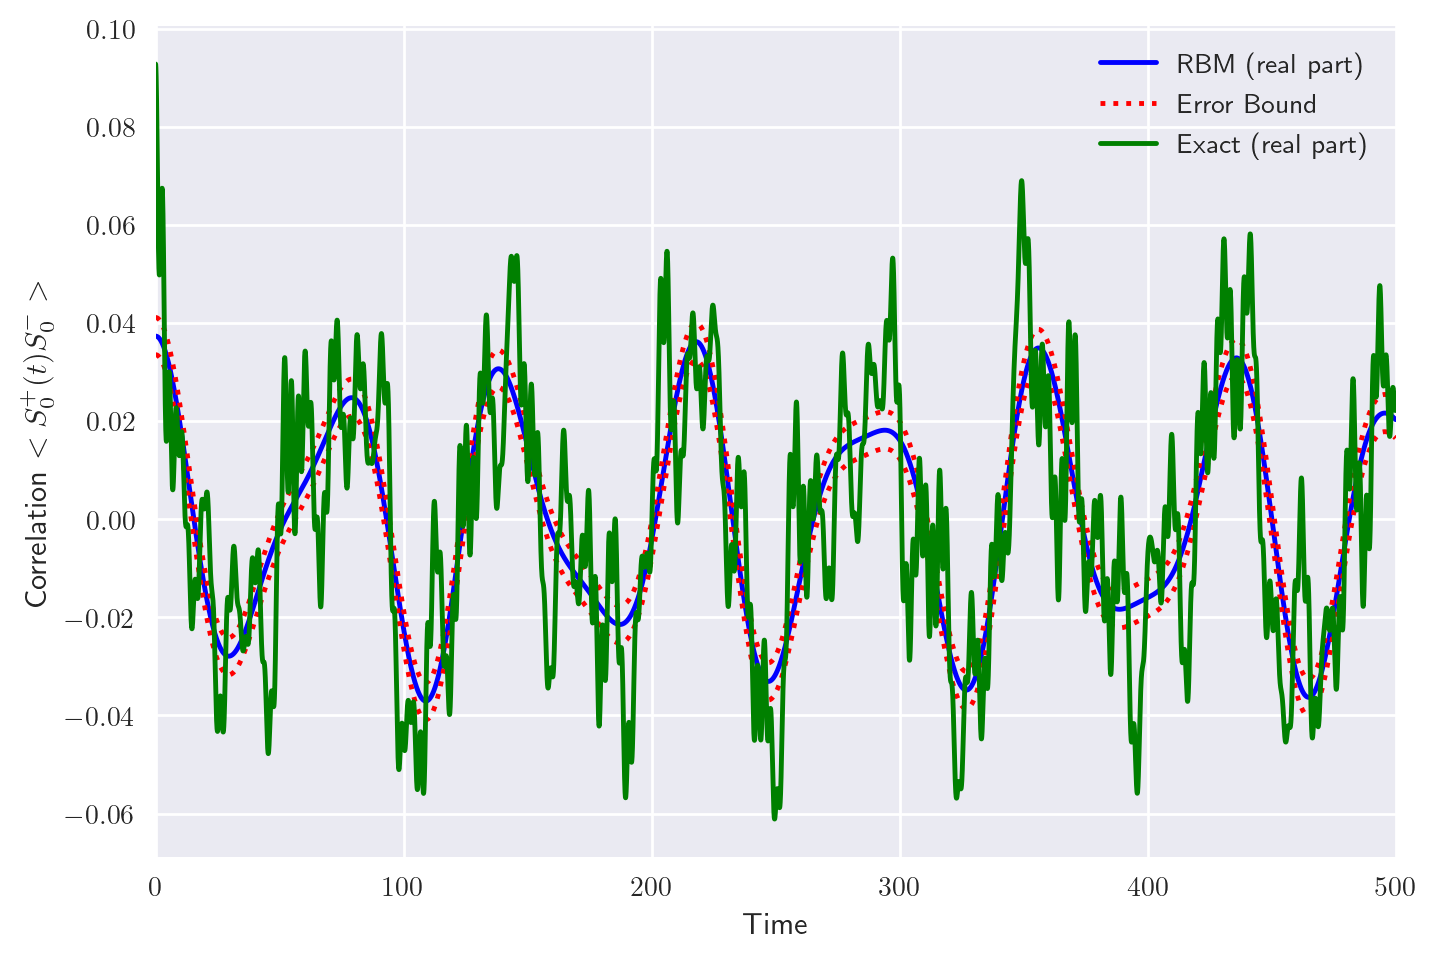

In [29]:
# let's plot!
plt.plot(time, np.real(corr), color='b', label = 'RBM (real part)')
plt.plot(time, np.real(corr)+0.00379412, color='r', linestyle = ':', label = 'Error Bound')
plt.plot(time, np.real(corr)-0.00379412, color='r', linestyle = ':')
#plt.plot(time_dense, np.real(corr_dense), color='r', label = 'exact_approx_real')
plt.plot(time_ex, np.real(corr_ex), color='g', label = 'Exact (real part)')
#plt.ylim(-0.383,-0.3829)
plt.legend()
plt.xlabel('Time')
plt.ylabel(r'Correlation $<S_{0}^{+}(t)S_{0}^{-}>$')
plt.xlim(0, 500)
plt.show()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


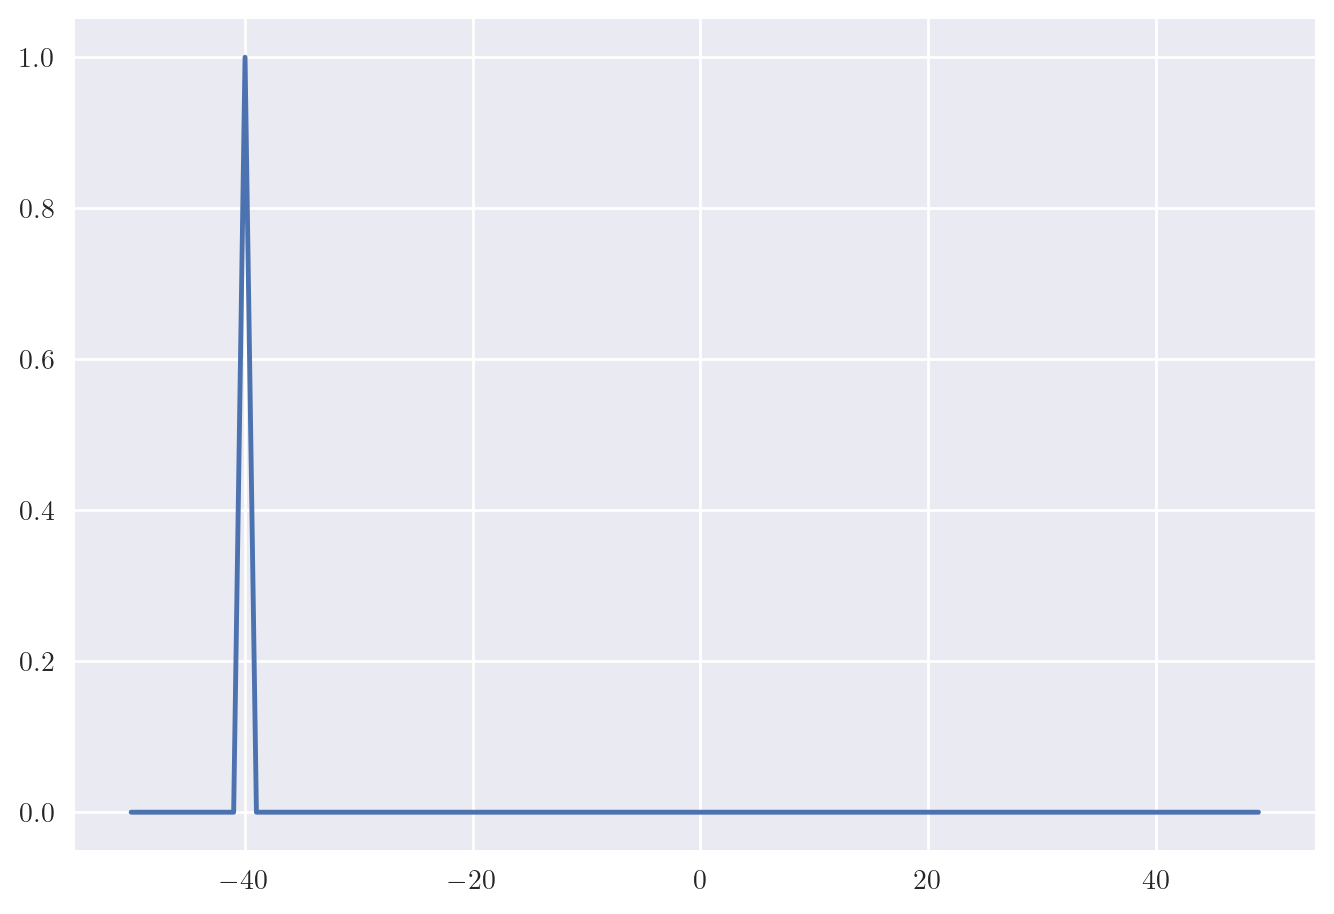

In [38]:
from scipy import signal
imp = signal.unit_impulse(100, idx=10)
plt.plot(np.arange(-50, 50), imp)
print(imp)
# now we do the analytic spectrum
#def spectrum()

In [70]:
# we first set up the range of angular frequencies we want
n_point = 5000
freq , step= np.linspace(-2, 2, n_point, retstep =True)
print(step)
print(freq.shape[0])

0.0008001600320064013
5000


In [71]:
# freq_range is a list of frequency values, returned from linspace
def analytic_spectrum(freq_range, freq_step, t_obver, obver, sta_list, eng_list, n_samples):
    # we first create a 1-D array of zeros 
    num = freq.shape[0]
    spectrum = np.zeros(num)
    
    #re-set the number of samples
    for ii in range(len(eng_list)):
        sta_list[ii].reset()
        sta_list[ii].n_samples = n_samples
    
    # we assume that there is no zero-frequency component
    for j in range(len(eng_list)-1):
        np.random.seed()
        initial_part = expect(t_obver, sta_list[0], sta_list[j+1]) * expect(obver, sta_list[j+1], sta_list[0])
        index = int( (-eng_list[j+1]+eng_list[0]) / freq_step + num/2 )
        spectrum += initial_part * 2 * np.pi * signal.unit_impulse(num, idx=index)
        
    return spectrum

def analytic_spectrum_exact(freq_range, freq_step, t_obver, obver, sta_list, eng_list):
    # we first create a 1-D array of zeros 
    num = freq.shape[0]
    spectrum = np.zeros(num, dtype = 'complex128')
    
    
    # we assume that there is no zero-frequency component
    for j in range(len(eng_list)-1):
        np.random.seed()
        initial_part = expected_2(t_obver, sta_list[0], sta_list[j+1]) * expected_2(obver, sta_list[j+1], sta_list[0])
        index = int( (-eng_list[j+1]+eng_list[0]) / freq_step + num/2 )
        spectrum += initial_part * 2 * np.pi * signal.unit_impulse(num, idx=index)
        
    return spectrum

In [72]:
rbm_freq = analytic_spectrum(freq, step, S_plus, S_minus, state_list, eng_list, n_samples_global )


expectation done once
expectation done once
expectation done once
expectation done once
expectation done once
expectation done once


In [73]:
exact_freq = analytic_spectrum_exact(freq, step, obver_p, obver_m, v, e )

Text(0, 0.5, 'Re( $\\mathcal{F}[<S_{0}^{+}(t)S_{0}^{-}>] (\\omega)$ )')

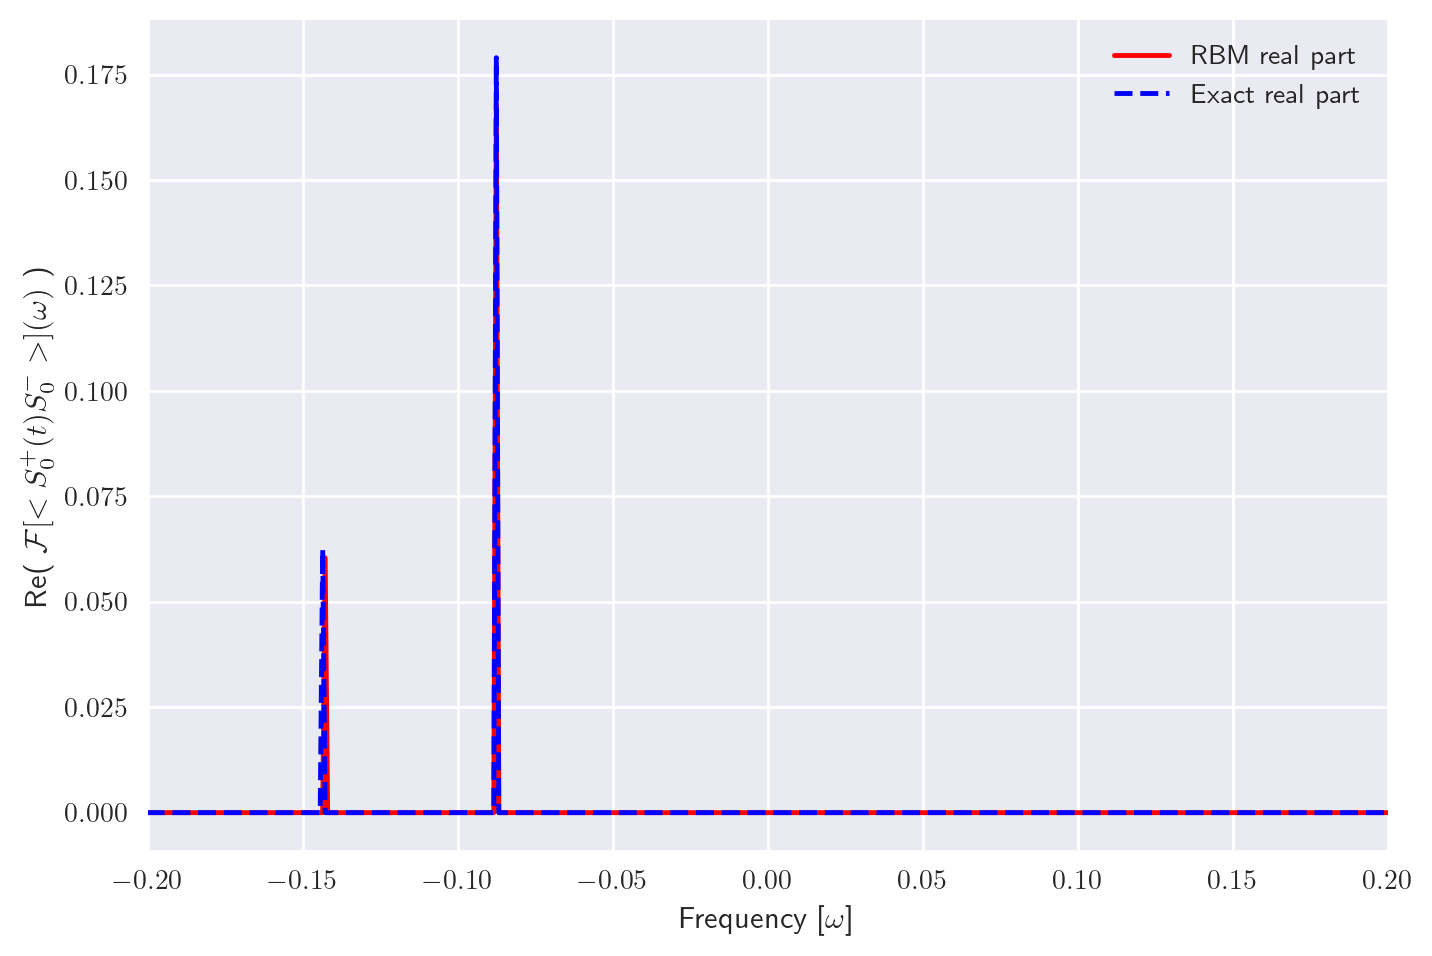

In [84]:
plt.plot(freq, np.real(rbm_freq), 'r', label = 'RBM real part')
plt.plot(freq, np.real(exact_freq), 'b--', label = 'Exact real part')
plt.legend()
plt.xlim(-0.2,0.2)
plt.xlabel(r'Frequency [$\omega$]')
plt.ylabel(r'Re( $\mathcal{F}[<S_{0}^{+}(t)S_{0}^{-}>] (\omega)$ )')

Text(0, 0.5, 'Im( $\\mathcal{F}[<S_{0}^{+}(t)S_{0}^{-}>] (\\omega)$ )')

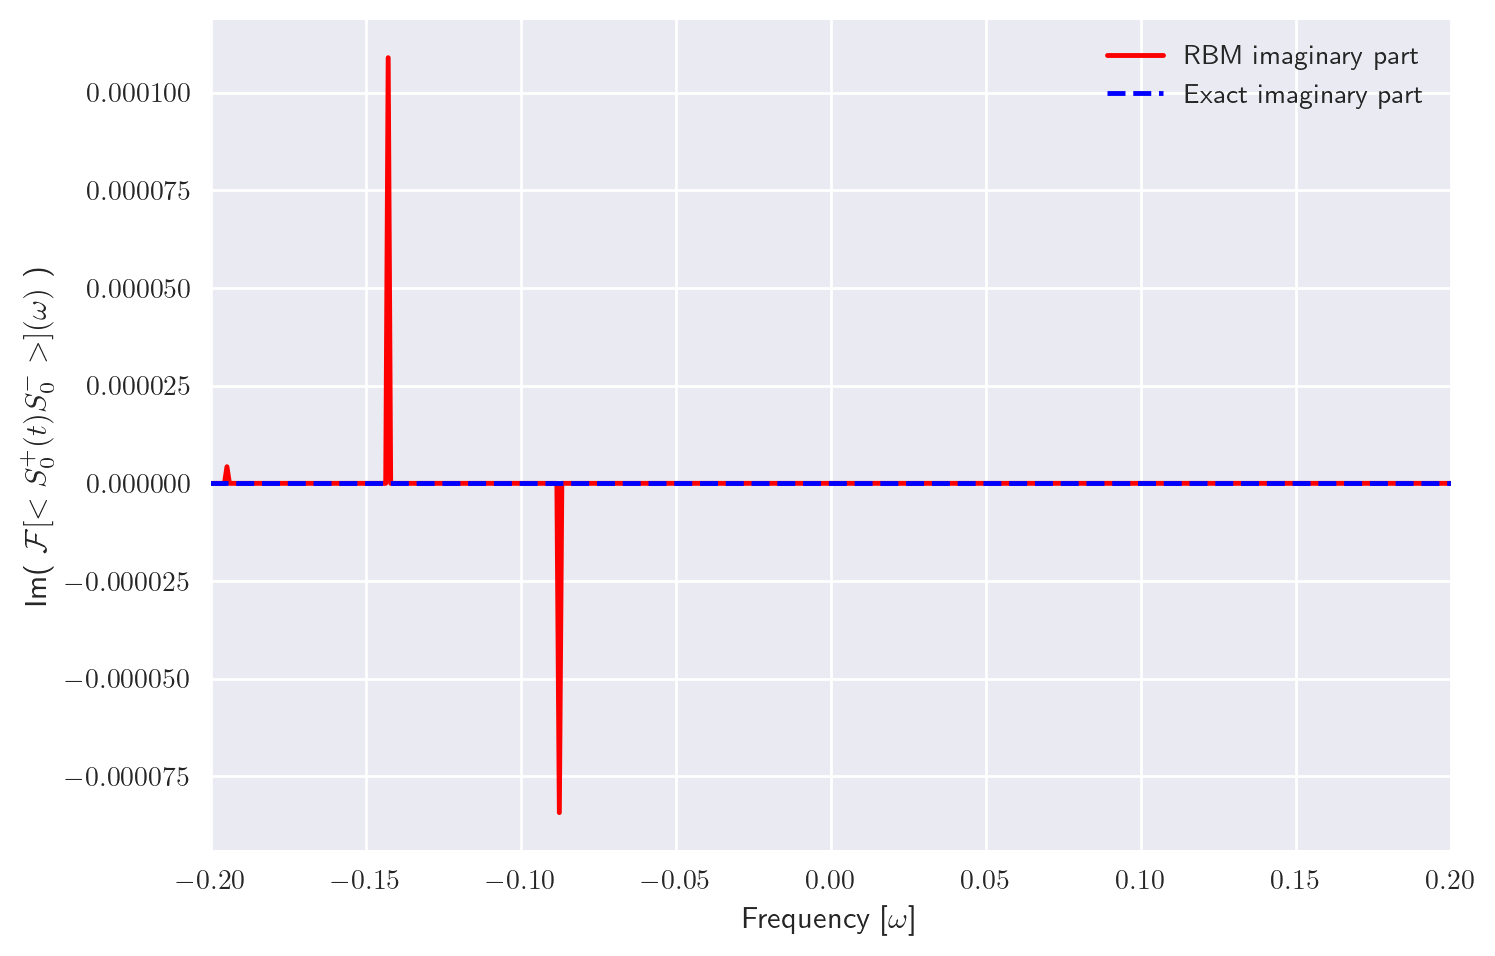

In [85]:
plt.plot(freq, np.imag(rbm_freq), 'r', label = 'RBM imaginary part')
plt.plot(freq, np.imag(exact_freq), 'b--', label = 'Exact imaginary part')
plt.legend()
plt.xlim(-0.2,0.2)
plt.xlabel(r'Frequency [$\omega$]')
plt.ylabel(r'Im( $\mathcal{F}[<S_{0}^{+}(t)S_{0}^{-}>] (\omega)$ )')